<a href="https://colab.research.google.com/github/krits29/regeneron-house-waste/blob/main/regeneron_house_waste.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian
jovian.set_project('regeneron-house-waste')
jovian.set_colab_id('17GG0OShLzQycPgbwwRcEOjGCWc-vV6Lr')

     |████████████████████████████████| 68 kB 3.2 MB/s 


# regeneron-house-waste

Use the "Run" button to execute the code.

In [2]:
!pip install jovian --upgrade --quiet

In [3]:
import jovian

In [4]:
# Execute this to save new versions of the notebook
jovian.commit(project="regeneron-house-waste")

[jovian] Detected Colab notebook...
[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ··········
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/krits29/regeneron-house-waste


'https://jovian.ai/krits29/regeneron-house-waste'

In [5]:
# Using 'opendatasets' and download https://www.kaggle.com/mostafaabla/garbage-classification

In [6]:
!pip install opendatasets --upgrade --quiet

In [7]:
import opendatasets as od

In [8]:
dataset_url = "https://www.kaggle.com/mostafaabla/garbage-classification"

In [9]:
od.download(dataset_url)


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: krits29
Your Kaggle Key: ··········


100%|██████████| 239M/239M [00:02<00:00, 85.6MB/s]


In [10]:
# import dataset into pytorch

In [11]:
data_dir = "./garbage-classification/garbage_classification"

In [12]:
import os

In [13]:
os.listdir(data_dir)

['paper',
 'battery',
 'clothes',
 'white-glass',
 'shoes',
 'trash',
 'cardboard',
 'metal',
 'biological',
 'plastic',
 'brown-glass',
 'green-glass']

In [14]:
# use ImageFolder class from torchvision

In [15]:
for cls in os.listdir(data_dir):
  print(cls, len(os.listdir(data_dir + "/" + cls)))

paper 1050
battery 945
clothes 5325
white-glass 775
shoes 1977
trash 697
cardboard 891
metal 769
biological 985
plastic 865
brown-glass 607
green-glass 629


## Import Dataset into Pytorch

In [16]:
from torchvision.datasets import ImageFolder

In [17]:
dataset = ImageFolder(data_dir)

In [18]:
len(dataset)

15515

In [19]:
dataset[0]

(<PIL.Image.Image image mode=RGB size=280x180 at 0x7FEA80512B10>, 0)

In [20]:
dataset.classes

['battery',
 'biological',
 'brown-glass',
 'cardboard',
 'clothes',
 'green-glass',
 'metal',
 'paper',
 'plastic',
 'shoes',
 'trash',
 'white-glass']

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

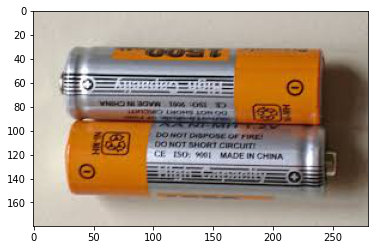

In [22]:
img, label = dataset[0]
plt.imshow(img)

In [23]:
import torchvision.transforms as tt

dataset = ImageFolder(data_dir, tt.Compose([tt.Resize(224), tt.RandomCrop(224), tt.ToTensor()]))

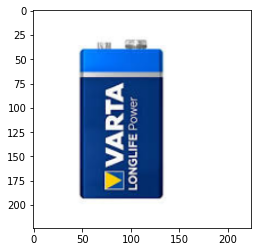

In [24]:
img, label = dataset[120]
plt.imshow(img.permute((1, 2, 0)))

In [25]:
# split dataset into validation and trainig dataset

In [26]:
val_percentage = 0.1
val_size = int(val_percentage * len(dataset))
train_size = len(dataset) - val_size

train_size, val_size

(13964, 1551)

In [27]:
from torch.utils.data import random_split

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(13964, 1551)

In [28]:
from torch.utils.data import DataLoader

batch_size = 256
# dataloader
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [29]:
from torchvision.utils import make_grid

def show_batch(dl):
  for images, labels in dl:
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


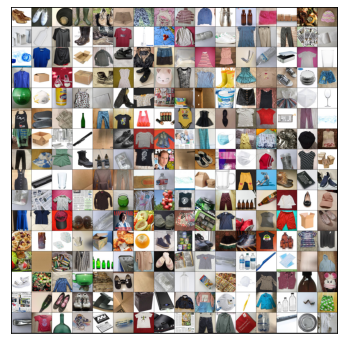

In [30]:
show_batch(train_dl)

### Utility Functions and Classes

### GPU Utilities

In [31]:
import torch

# Use GPU is available, else CPU
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

# Move tensors to the gpu/cpu
def to_device(data, device):
  if isinstance(data, (list,tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_bloacking=True)

class DeviceDataLoader():
  # Wrap dataloader to move data to a device
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  # Yield batch of data after moving data to device
  def __iter__(self):
    for b in self.dl:
      yield to_device(b, self.device)

  # Return number of batches
  def __len__(self):
    return len(self.dl)

In [32]:
torch.cuda.is_available()

True

In [33]:
device = get_default_device()
device

device(type='cuda')

In [34]:
img, label = dataset[0]

In [35]:
img.shape

torch.Size([3, 224, 224])

In [36]:
img.device

device(type='cpu')

In [37]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

### Model and Training Utilities

In [47]:
import torch.nn as nn

class ImageClassificationBas(nn.Module):
  def training_step(self, batch):
    # calculate loss for a batch of training data
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    return loss

  def validation_step(self, batch):
    # calculate loss and accuract for a batch of validation data
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels) # calculate loss
    acc = accuracy(out, labels)         # calculate accuracy
    return {'val_loss': loss.detach(), 'val_acc': acc}

  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

  def epoch_end(self, epoch, results):
    print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
        epoch, result['train_loss'], result['val_loss'], result['val_acc']))
    
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [38]:
@torch.no_grad()
def evaluate(model, val_loader):
  #Evaluates the model's performance on the validation data set
  model.eval()
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
  history = []
  optimizer = opt_func(model.parameters(), lr)
  for epoch in range(epochs):
    # Train
    model.train()
    train_losses = []
    for batch in train_loader:
      loss = model.training_step(batch)
      train_losses.append(loss)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    #Validation
    result = evaluate(model, val_loader)
    result['train_loss'] = torch.stack(train_losses).mean().item()
    model.epoch_end(epoch, result)
    history.append(result)
  return history

## Model